# Initialization
- load functions
- example data (Heidi 2003 exampel data, 1 day Synechococcus)

In [1]:
library(R.matlab)
df <- readMat("~/Documents/DATA/Codes/ssPopModel/inst/sosik2003/day733320data.mat")
time <- seq(0,1+3600*24,by=3600)
volbins <- (df$volbins) #  fg (instead of volume)
V.hists <- df$Vhists
	colnames(V.hists) <- time
	row.names(V.hists) <- volbins
N.dist <- df$N.dist
	colnames(N.dist) <- time
	row.names(N.dist) <- volbins
	Ntot <- colSums(N.dist)
Edata <- df$Edata
	Edata[,1] <- seq(range(time)[1], range(time)[2], length.out=nrow(Edata))

resol <- 10
dt <- resol/60
	ime.interval <- median(diff(as.numeric(colnames(V.hists))))
	ti <- as.numeric(colnames(V.hists))

	# create Light data with 'dt' time interval.
		seq <- NULL
		for(i in 1:(length(ti)-1)){
			s <- seq(ti[i], ti[i+1], length.out=1/dt)
			seq <- c(seq, s)
		}

	ep <- data.frame(spline(Edata[,1], Edata[,2], xout=seq)) #interpolate E data according to dt resolution
	Einterp <- ep$y
	Einterp[Einterp < 0] <- 0


results <- readMat("~/Documents/DATA/Codes/ssPopModel/inst/sosik2003/results.mat")
	Vproj <- results$Vproj
	colnames(Vproj) <- time
	row.names(Vproj) <- volbins

	params <- results$modelresults[-1]
	gmax <- params[1]
	a <- params[2]
	b <- params[3]
	E_star <- params[4]
	dmax <- params[5]
	c <- 1.5

	hr <- 1


######
require(DEoptim)

		dt <- resol/60
		time.interval <- median(diff(as.numeric(colnames(V.hists))))
		# dt <- 1/6; breaks <- 25 ## MATLAB
		ti <- as.numeric(colnames(V.hists))

		# create Light data with 'dt' time interval.
			seq <- NULL
			for(i in 1:(length(ti)-1)){
				s <- seq(ti[i], ti[i+1], length.out=1/dt)
				seq <- c(seq, s)
			}

		ep <- data.frame(spline(Edata[,1], Edata[,2], xout=seq)) #interpolate E data according to dt resolution
		Einterp <- ep$y
		Einterp[Einterp < 0] <- 0



###############
## sigma.lsq ##
###############
# This function calculates the sum of squares of the of the differences between the hourly observations and the model given the specified parameters
# This function returns a column vector - called by "determine.opt.para" for the optimization.

	.sigma.lsq <- function(params, Einterp, N.dist, V.hists, resol){

				time.interval <- median(diff(as.numeric(colnames(V.hists))))
				res <- which(diff(as.numeric(colnames(V.hists))) == time.interval)# select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
				dim <- dim(N.dist)
				sigma <- matrix(NA, dim[1], dim[2]-1) # preallocate sigma
				TotN <- as.matrix(colSums(N.dist))
				volbins <- as.numeric(row.names(V.hists))

			for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=as.numeric(params[1]), dmax=as.numeric(params[2]), b=as.numeric(params[3]), E_star=as.numeric(params[4]),  c=as.numeric(params[5]), d=as.numeric(params[6]),resol=resol)
					wt <- B %*% V.hists[,hr] # calculate the projected size-frequency distribution
					wt.norm <- wt/sum(wt, na.rm=T) # normalize distribution

					# Nproj <- round(TotN[hr+1]*wt.norm)
					# med.pred <- which(Nproj == max(Nproj))
					# width.pred <- diff(range(which(Nproj > 0)))
					# med.obs <- which(V.hists[,hr] == max(V.hists[,hr]))
					# width.obs <- diff(range(which(N.dist[,hr] > 0)))
					# distorsion <- as.vector((min.obs - min.pred)^2 + 2*(med.pred - med.obs)^2)

					sigma[,hr] <-  (N.dist[, hr+1] - round(TotN[hr+1]*wt.norm))^2 # ABSOLUTE observed value - fitted value
					#sigma[,hr] <- ((N.dist[, hr+1] - round(TotN[hr+1]*wt.norm))/TotN[hr+1]))^2 # RELATIVE observed value - fitted value
					# mean.size.pred <- sum(volbins*wt.norm)
					# mean.size.obs <-  sum(volbins*V.hists[, hr+1])
					# sd.pred <- sqrt(sum((volbins - mean.size.pred)^2)/length(volbins))
					# sd.obs <- sqrt(sum((volbins - mean.size.obs)^2)/length(volbins))
					# sigma[,hr] <- (mean.size.obs - mean.size.pred)/sqrt(sd.obs/TotN[hr+1] + sd.pred/TotN[hr+1])
					}
			sigma <- colSums(sigma)/colSums(N.dist[,-1])
			sigma <- mean(sigma, na.rm=T)
			return(sigma)

}

R.matlab v3.6.2 (2018-09-26) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Loading required package: DEoptim
Loading required package: parallel

DEoptim package
Differential Evolution algorithm in R
Authors: D. Ardia, K. Mullen, B. Peterson and J. Ulrich



# 1. ORIGINAL model

## 1a. Load Matrix ORIGINAL Model

In [2]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, c, d, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of growth rate
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)

				# From Szul et al., 2019 mSystems. At Pro growth rate of 0.44 d-1 (or 0.0183 h-1), proportion of carbon storage to total carbon ~ 30%
				# From Zavrel et al. 2019 eLife. At Synechocystis growth rate of 44 d-1, proportion of carbon storage to total carbon ~ 7.4 % [100*(1.35 * 0.44/24 + 0.05018)]
						# Simplification: reg <- lm(seq(0.084, 0.199, length.out=10) ~ seq(0.025, 0.11, length.out=10))#
				# converson Synechocystis to Prochlorococcus ~ 4 [0.3 / (1.35 * 0.44/24 + 0.05018)]
		conv <- 0.3 / (1.35 * 0.44/24 + 0.05018)
 		c <- 0
		d <-  conv*(1.35294 * mean(y) + 0.05018) # proportion of carbon storage to total carbon
 		resp <- d * mean(y)
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}

		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal stasis (0)
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal growth (-1)
		resp_ind <- seq(m+1, m^2, by=m+1) # superdiagonal (+1)
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal division (j-1)
		n <- length(volbins)

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			allo <- d * (volbins^-1.3) # allometric relationship of carbon metabolism
			allo <- log(allo/ min(allo))
			#allo[which(allo > 5)]<- 5 # to limit difference in rate between smallest and largest size
 			allo <- rep(1,n) # no allometric relationship
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 1b. Optmization

In [3]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6), upper=c(1,1,15,max(Einterp),15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax <- params[1]
		dmax <- params[2]
		b <- params[3]
		E_star <- params[4]
		c <- params[5]
		d <- params[6]
		resnorm <- opt$optim$bestval


Iteration: 10 bestvalit: 5.577612 bestmemit:    0.173483    0.045754    3.529331  107.465353    3.581688
Iteration: 20 bestvalit: 5.097663 bestmemit:    0.162088    0.029522    4.008725  225.769072    7.249005
Iteration: 30 bestvalit: 5.011087 bestmemit:    0.175481    0.040430    3.976282  245.742341    4.394303
Iteration: 40 bestvalit: 4.990564 bestmemit:    0.165815    0.037459    4.092022  224.785809    0.812885
Iteration: 50 bestvalit: 4.981724 bestmemit:    0.167284    0.035928    3.997048  255.976977    6.515247
Iteration: 60 bestvalit: 4.978144 bestmemit:    0.165020    0.036006    4.005181  252.247706    8.845289
Iteration: 70 bestvalit: 4.974433 bestmemit:    0.167523    0.037102    4.045558  250.827811   11.039431
Iteration: 80 bestvalit: 4.974433 bestmemit:    0.167523    0.037102    4.045558  250.827811   11.039431
Iteration: 90 bestvalit: 4.974226 bestmemit:    0.165544    0.035628    4.041289  257.161755   10.686174
Iteration: 100 bestvalit: 4.973917 bestmemit:    0.1655

## 1c. Results

        par1         par2         par3         par4         par5 
  0.16554431   0.03562759   4.04128912 258.56862551  13.71112383 
[1] "daily growth rate= 0.73"


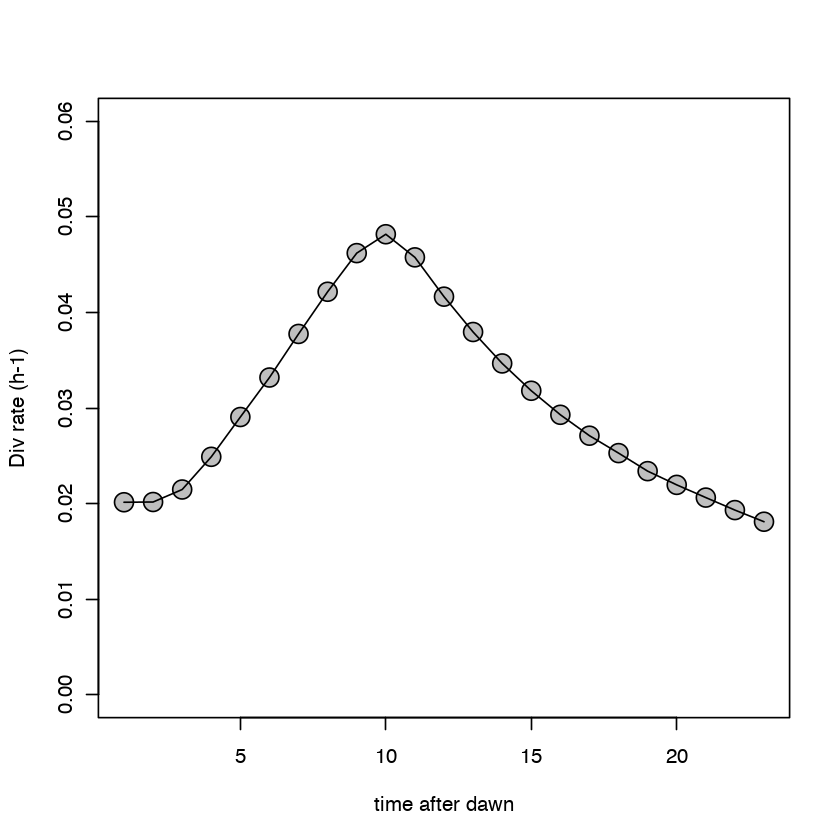

In [4]:
		####################################################
		## Calculate projections from best fit parameters ##
		####################################################
		print(params)

		res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
		Vproj <- V.hists
		Nproj <- N.dist
		mu_N <- matrix(nrow=1,ncol=dim(V.hists)[2])
		volbins <- as.numeric(row.names(V.hists))

		for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax, dmax=dmax,b=b, E_star=E_star,c=c, d=d, resol=resol)
					Nproj[,hr+1] <- round(B %*% Nproj[,hr]) # calculate numbers of individuals
					Vproj[,hr+1] <- B %*% Vproj[,hr] # calculate the projected size-frequency distribution
					Vproj[,hr+1] <- Vproj[,hr+1]/sum(Vproj[,hr+1]) # normalize distribution so sum = 1
					mu_N[,hr+1] <- log(sum(Nproj[,hr+1])/sum(Nproj[,hr]))/
								((as.numeric(colnames(Nproj)[hr+1])-as.numeric(colnames(Nproj)[hr]))/(time.interval))
						}
		Nproj <- colSums(Nproj)
		colnames(mu_N) <- colnames(Vproj)

		#############################
		## Growth rate calculation ##
		#############################
		d.mu_N <- 24*mean(mu_N[-c(1:2)], na.rm=T)
		print(paste("daily growth rate=",round(d.mu_N,2)))

plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))


# 2. Model with Respiration


## 2a. Load matrix model

In [5]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, c, d, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of growth rate
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)

				# From Szul et al., 2019 mSystems. At Pro growth rate of 0.44 d-1 (or 0.0183 h-1), proportion of carbon storage to total carbon ~ 30%
				# From Zavrel et al. 2019 eLife. At Synechocystis growth rate of 44 d-1, proportion of carbon storage to total carbon ~ 7.4 % [100*(1.35 * 0.44/24 + 0.05018)]
						# Simplification: reg <- lm(seq(0.084, 0.199, length.out=10) ~ seq(0.025, 0.11, length.out=10))#
				# converson Synechocystis to Prochlorococcus ~ 4 [0.3 / (1.35 * 0.44/24 + 0.05018)]
		conv <- 0.3 / (1.35 * 0.44/24 + 0.05018)
 		# c <- 0
		d <-  conv*(1.35294 * mean(y) + 0.05018) # proportion of carbon storage to total carbon
 		resp <- d * mean(y)
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}

		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal stasis (0)
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal growth (-1)
		resp_ind <- seq(m+1, m^2, by=m+1) # superdiagonal (+1)
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal division (j-1)
		n <- length(volbins)

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			allo <- d * (volbins^-1.3) # allometric relationship of carbon metabolism
			allo <- log(allo/ min(allo))
			#allo[which(allo > 5)]<- 5 # to limit difference in rate between smallest and largest size
 			allo <- rep(1,n) # no allometric relationship
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 2b. Optimization

In [6]:
f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6), upper=c(1,1,15,max(Einterp),15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax2 <- params[1]
		dmax2 <- params[2]
		b2 <- params[3]
		E_star2 <- params[4]
		c2 <- params[5]
		d2 <- params[6]
		resnorm2 <- opt$optim$bestval

Iteration: 10 bestvalit: 5.073216 bestmemit:    0.189357    0.032444    4.536898  280.405075    0.924139
Iteration: 20 bestvalit: 5.073216 bestmemit:    0.189357    0.032444    4.536898  280.405075    0.924139
Iteration: 30 bestvalit: 4.767550 bestmemit:    0.153921    0.027975    4.180970  250.307280    1.193550
Iteration: 40 bestvalit: 4.747181 bestmemit:    0.147905    0.029726    4.534142  263.995845    1.202787
Iteration: 50 bestvalit: 4.742166 bestmemit:    0.147905    0.029726    4.534142  253.219923    1.202787
Iteration: 60 bestvalit: 4.737977 bestmemit:    0.141973    0.027102    4.774866  255.620728    1.550982
Iteration: 70 bestvalit: 4.729786 bestmemit:    0.142810    0.026568    4.586743  257.060151    1.522769
Iteration: 80 bestvalit: 4.729429 bestmemit:    0.144311    0.027380    4.542453  258.422431    1.349727
Iteration: 90 bestvalit: 4.729394 bestmemit:    0.144311    0.027380    4.542453  258.381981    1.349727
Iteration: 100 bestvalit: 4.728997 bestmemit:    0.1443

## 2c. Results

        par1         par2         par3         par4         par5 
  0.14569549   0.02689613   4.62092230 258.44828926   1.42115697 
[1] "daily growth rate= 0.49"


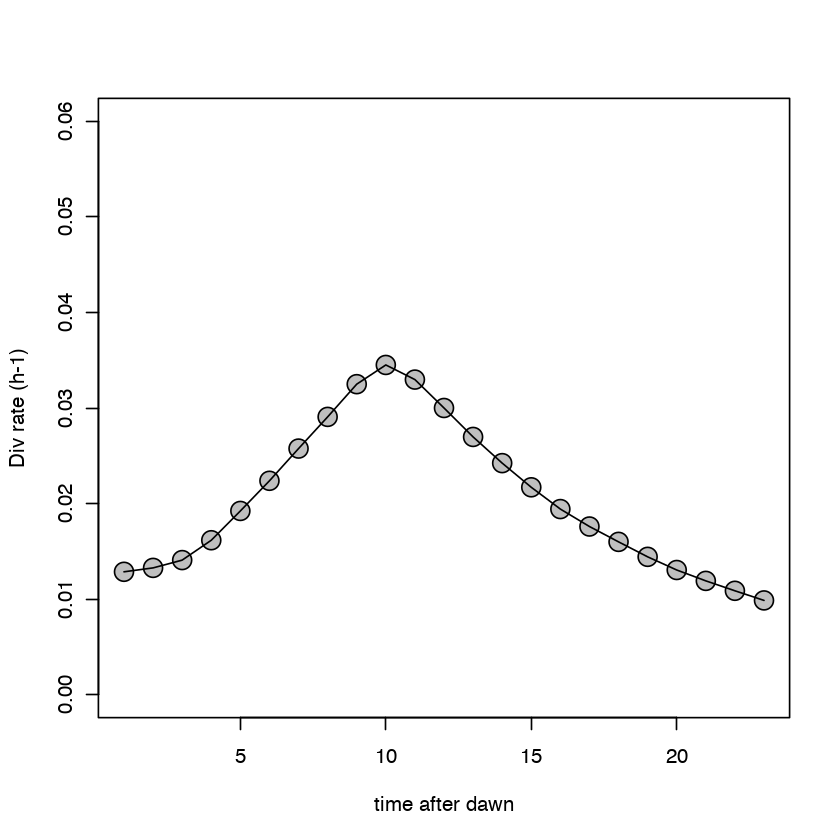

In [7]:
		####################################################
		## Calculate projections from best fit parameters ##
		####################################################
		print(params)

		res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
		Vproj <- V.hists
		Nproj <- N.dist
		mu_N2 <- matrix(nrow=1,ncol=dim(V.hists)[2])
		volbins <- as.numeric(row.names(V.hists))

		for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax2, dmax=dmax2,b=b2, E_star=E_star2,c=c2, d=d2, resol=resol)
					Nproj[,hr+1] <- round(B %*% Nproj[,hr]) # calculate numbers of individuals
					Vproj[,hr+1] <- B %*% Vproj[,hr] # calculate the projected size-frequency distribution
					Vproj[,hr+1] <- Vproj[,hr+1]/sum(Vproj[,hr+1]) # normalize distribution so sum = 1
					mu_N2[,hr+1] <- log(sum(Nproj[,hr+1])/sum(Nproj[,hr]))/
								((as.numeric(colnames(Nproj)[hr+1])-as.numeric(colnames(Nproj)[hr]))/(time.interval))
						}
		Nproj <- colSums(Nproj)
		colnames(mu_N2) <- colnames(Vproj)

		#############################
		## Growth rate calculation ##
		#############################
		d.mu_N2 <- 24*mean(mu_N2[-c(1:2)], na.rm=T)
		print(paste("daily growth rate=",round(d.mu_N2,2)))

plot(mu_N2[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))


# 3 Model with Respiration + Allometric functions

## 3a. Load matrix model

In [8]:
#######################
## matrix.conct.fast ##
#######################
#Construct matrix A(t) for each time step within an hour based on delta and gamma at each 10 minute time intervals then construct B(t) which is A(t)'s multiplied for the given hour
#multiply B(t)*w(t) to get the projection to next hour dist if desired

.matrix.conct.fast <- function(hr, Einterp, volbins, gmax, dmax, b, E_star, c, d, resol){

		########################
		## INITIAL PARAMETERS ##
		########################
		t.nodiv <- 0 # no division during the first X hours after dawn
		dt <- resol/60
		j <- findInterval(2 * volbins[1], volbins)
		m <- length(volbins) ## dimensions of the squared matrix

		####################
		## GAMMA FUNCTION ## fraction of cells that grow into next size class between t and t + dt
		####################
		# y <- (1-exp(-Einterp/E_star)) * gmax # original 2003 model
		y <- (gmax/E_star) * Einterp # NEW VERSION
		y[which(Einterp >= E_star)] <- gmax

		##########################
		## Respiration FUNCTION ## fraction of cells that shrink between t and t + dt
		##########################
				# Assumptions:
				# 1) rate of respiration is a function of growth rate
				# 2) rate of respiration constant (h-1) constant over the nighttime period (polysaccharide is drawn down linearly over the nighttime period)

				# From Szul et al., 2019 mSystems. At Pro growth rate of 0.44 d-1 (or 0.0183 h-1), proportion of carbon storage to total carbon ~ 30%
				# From Zavrel et al. 2019 eLife. At Synechocystis growth rate of 44 d-1, proportion of carbon storage to total carbon ~ 7.4 % [100*(1.35 * 0.44/24 + 0.05018)]
						# Simplification: reg <- lm(seq(0.084, 0.199, length.out=10) ~ seq(0.025, 0.11, length.out=10))#
				# converson Synechocystis to Prochlorococcus ~ 4 [0.3 / (1.35 * 0.44/24 + 0.05018)]
		conv <- 0.3 / (1.35 * 0.44/24 + 0.05018)
# 		c <- 0
		d <-  conv*(1.35294 * mean(y) + 0.05018) # proportion of carbon storage to total carbon
 		resp <- d * mean(y)
		resp <- c * (resp - y) # transform to probability to decrease size over time period
		resp[which(resp < y)] <- 0 # probablity to decrease size class is 0 when growth rate > respiration rate

			# plot(y); points(resp,col=2); abline(h=c(mean(y), mean(resp)),col=c(1,2))
			# print(mean(resp)/mean(y))

		####################
		## DELTA FUNCTION ## fraction of cells that divide between t and t + dt
		####################
		a <- 4 	# NOTE: most values of volbins need to be < 1 for compatibility issue with the Delta function # based on HYNES et al. 2015
		del <- dmax * (a*volbins/max(volbins))^b / (1 + (a*volbins/max(volbins))^b)

		# del[1:(j-1)] <- 0
				if(hr <= t.nodiv){delta <- matrix(data=0, 1, m)
					}else{delta <- matrix(del, 1, m)}

		## PLOT GAMMA AND DELTA
		# par(mfrow=c(3,1))
		# plot(y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(resp,col='lightblue')
		# plot(Einterp, y, type='p', col='red', xlab="Radiations", ylab=paste("Gamma (per",60*dt,"min)")); points(Einterp, resp,col='lightblue')
		# plot(volbins, del, type='p', col='red', xlab="Cell volume", ylab=paste("Delta (per",60*dt,"min)"))

		################################
		## CONSTRUCTION SPARSE MATRIX ##
		################################
		stasis_ind <- seq(1,m^2,by=m+1) # Diagonal stasis (0)
		growth_ind <- seq(2,m^2,by=m+1) # Subdiagonal growth (-1)
		resp_ind <- seq(m+1, m^2, by=m+1) # superdiagonal (+1)
		div_ind <- seq((((j-1)*m)+1), m^2, by=m+1) # Superdiagonal division (j-1)
		n <- length(volbins)

		for(t in 1:(1/dt)){
			#t <- 1
			A <- matrix(data=0,nrow=m, ncol=m)
			allo <- d * (volbins^-1.3) # allometric relationship of carbon metabolism
			allo <- log(allo/ min(allo))
			#allo[which(allo > 5)]<- 5 # to limit difference in rate between smallest and largest size
# 			allo <- rep(1,n) # no allometric relationship
			gamma <- y[t+hr/dt]*allo
			respiration <- resp[t+hr/dt]*allo

			# plot(volbins, gamma); abline(h=c(y[t+hr/dt] , mean(gamma)), col=c(1,2));points(volbins, respiration,col=3)

			# Stasis (main diagonal)
			A[stasis_ind] <- (1-delta)*(1-gamma)*(1-respiration) # the hr/dt part in the indexing is because each hour is broken up into dt segments for the irradiance spline
			A[m,m] <- (1-delta[m])*(1-respiration[m])

			# Cell growth (subdiagonal)
			A[growth_ind] <- gamma[1:(m-1)]*(1-delta[1:(m-1)])*(1-respiration[1:(m-1)])

			# Division (first row and superdiagonal j-1)
			A[1,1:(j-1)] <- 2 * delta[1:(j-1)] # Top row; Small phytoplanktoin (i=1,..., j-1) are less than twice as big as the smallest size class, and so newly divided are put in the smallest size class.
			A[div_ind] <- 2 * delta[j:m] # The cell division terms for large (i > = j) phytoplankton

			# Respiration (superdiagonal)
			A[1,2] <- A[1,2]  + respiration[1]
			A[resp_ind] <- respiration[-1]*(1-delta[-1])*(1-gamma[-1])

					if(t == 1){B <- A}else{B <- A %*% B}
			}

		return(B)
}

## 3b. Optimization

In [9]:
	f <- function(params) .sigma.lsq(params=params, Einterp=Einterp, N.dist=N.dist, V.hists=V.hists, resol=resol)

		opt <- DEoptim(f, lower=c(1e-6,1e-6,1e-6,1,1e-6), upper=c(1,1,15,max(Einterp),15), control=DEoptim.control(itermax=1000, reltol=1e-3, trace=10, steptol=100, strategy=2, parallelType=0))
		params <- opt$optim$bestmem
		gmax3 <- params[1]
		dmax3 <- params[2]
		b3 <- params[3]
		E_star3 <- params[4]
		c3 <- params[5]
		d3 <- params[6]
		resnorm3 <- opt$optim$bestval

Iteration: 10 bestvalit: 6.547677 bestmemit:    0.084417    0.028105    5.185939  463.608734    3.263985
Iteration: 20 bestvalit: 5.177686 bestmemit:    0.057477    0.017785    3.961358  359.910300    4.203219
Iteration: 30 bestvalit: 4.844820 bestmemit:    0.053531    0.028132    3.601255  275.095317    0.557964
Iteration: 40 bestvalit: 4.695815 bestmemit:    0.048968    0.021290    3.790871  218.166962    1.890275
Iteration: 50 bestvalit: 4.650035 bestmemit:    0.052387    0.023001    4.023352  232.119159    1.947291
Iteration: 60 bestvalit: 4.635405 bestmemit:    0.052387    0.023001    4.023352  254.998269    2.107602
Iteration: 70 bestvalit: 4.631430 bestmemit:    0.052326    0.022765    4.024449  259.097048    2.393757
Iteration: 80 bestvalit: 4.629796 bestmemit:    0.053613    0.023952    3.960694  257.679523    2.093811
Iteration: 90 bestvalit: 4.628540 bestmemit:    0.053670    0.023996    3.957986  257.333821    2.158978
Iteration: 100 bestvalit: 4.627708 bestmemit:    0.0543

## 3c. Results

        par1         par2         par3         par4         par5 
  0.05425684   0.02477223   4.03259229 257.70270838   2.07523133 
[1] "daily growth rate= 0.47"


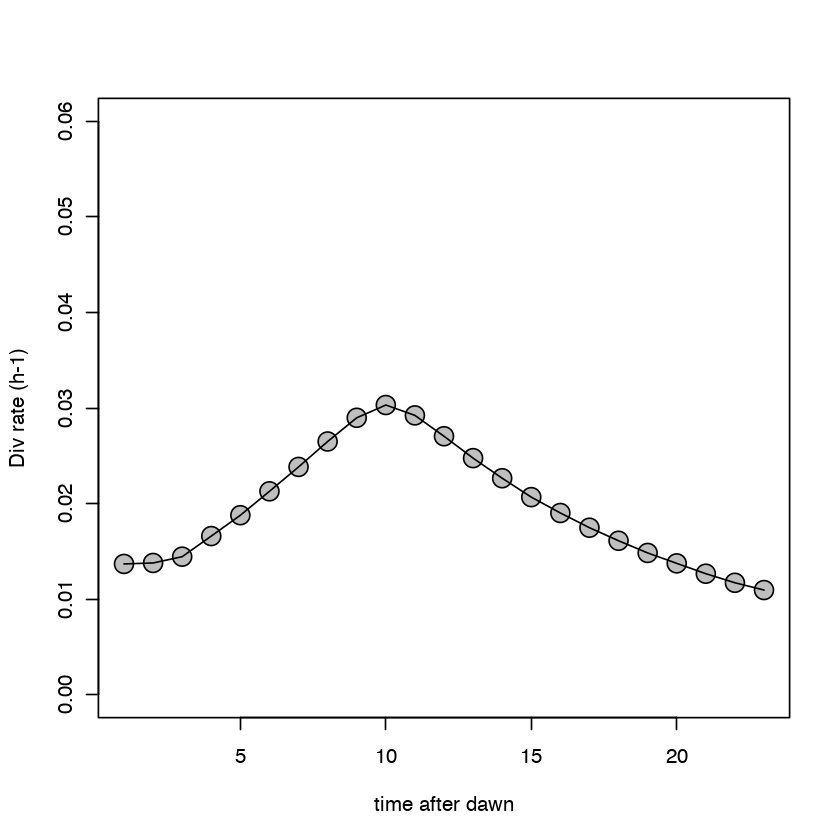

In [10]:
		####################################################
		## Calculate projections from best fit parameters ##
		####################################################
		print(params)

		res <- which(diff(as.numeric(colnames(V.hists))) == time.interval) # select time that have at least 2 consecutive time points, required for comparing the projection to the next time point
		Vproj <- V.hists
		Nproj <- N.dist
		mu_N3 <- matrix(nrow=1,ncol=dim(V.hists)[2])
		volbins <- as.numeric(row.names(V.hists))

		for(hr in res){
					B <- .matrix.conct.fast(hr=hr-1, Einterp=Einterp, volbins=volbins, gmax=gmax3, dmax=dmax3,b=b3, E_star=E_star3,c=c3, d=d3, resol=resol)
					Nproj[,hr+1] <- round(B %*% Nproj[,hr]) # calculate numbers of individuals
					Vproj[,hr+1] <- B %*% Vproj[,hr] # calculate the projected size-frequency distribution
					Vproj[,hr+1] <- Vproj[,hr+1]/sum(Vproj[,hr+1]) # normalize distribution so sum = 1
					mu_N3[,hr+1] <- log(sum(Nproj[,hr+1])/sum(Nproj[,hr]))/
								((as.numeric(colnames(Nproj)[hr+1])-as.numeric(colnames(Nproj)[hr]))/(time.interval))
						}
		Nproj <- colSums(Nproj)
		colnames(mu_N3) <- colnames(Vproj)

		#############################
		## Growth rate calculation ##
		#############################
		d.mu_N <- 24*mean(mu_N3[-c(1:2)], na.rm=T)
		print(paste("daily growth rate=",round(d.mu_N,2)))

plot(mu_N3[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))


# 4. Summary

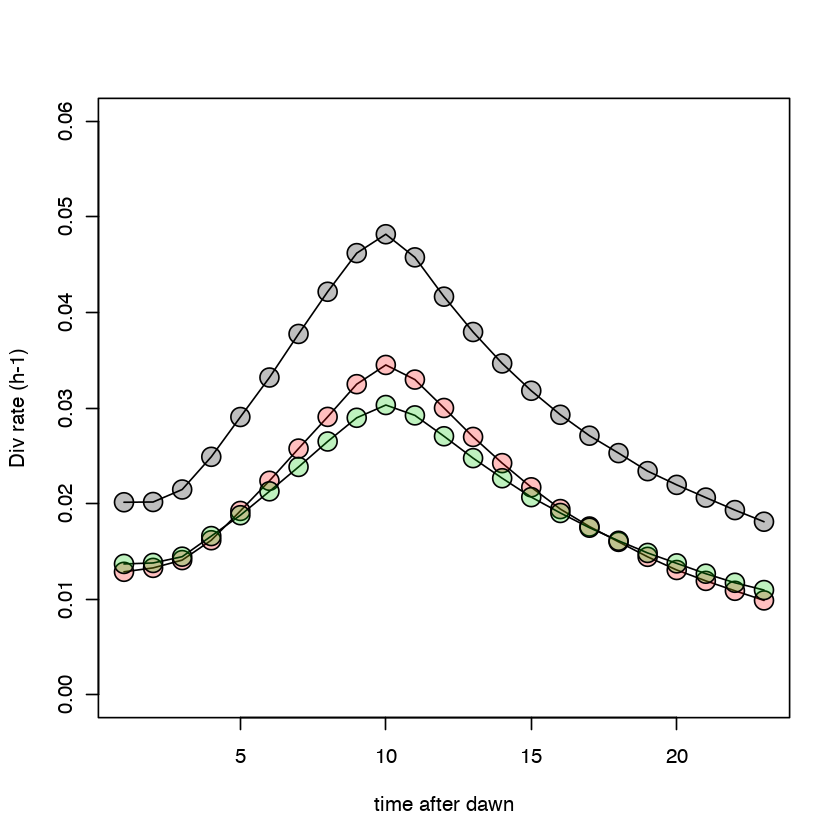

In [12]:
plot(mu_N[-c(1:2)],type='o', ylim=c(0,0.06), xlab='time after dawn', ylab="Div rate (h-1)", pch=21, cex=2, bg=adjustcolor(1,0.25))
    points(mu_N2[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(2,0.25))
    points(mu_N3[-c(1:2)],type='o', pch=21, cex=2, bg=adjustcolor(3,0.25))
